In [2]:
import torch
import numpy as np
from torch import nn
from torch.autograd import Variable
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.utils.data as data_utils
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import datasets

import time

In [3]:
torch.manual_seed(1)    # reproducible
# Hyper Parameters
#EPOCH=1             
EPOCH=45                # train the training data n times
#BATCH_SIZE = 180
TIME_STEP = 10          # rnn time step 
INPUT_SIZE = 10         # rnn input size 
LR = 0.01               # learning rate

In [4]:
data = np.load('data_task2.npy') #load data
label=np.load('label_task2.npy') #load label
data_train, data_test, label_train, label_test = train_test_split(data,label,
    test_size=0.25, random_state=75)
data_train= torch.FloatTensor(data_train)

label_train=torch.LongTensor(label_train) #convert to long
datasett= data_utils.TensorDataset(data_train, label_train) #get dataset as whole
trainloader = data_utils.DataLoader(datasett) #load dataset
data_test = torch.Tensor(data_test) #convert to tensor type
label_test = torch.LongTensor(label_test) #convert to long
testsett= data_utils.TensorDataset(data_test, label_test) #get the dataset as whole
testloader = data_utils.DataLoader(testsett) #load the dataset

In [5]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()

        self.rnn = nn.LSTM(         # if use nn.RNN(), it hardly learns
            input_size=INPUT_SIZE,
            hidden_size=64,         # rnn hidden unit
            num_layers=1,           # number of rnn layer
            batch_first=True,       # input & output will has batch size as 1s dimension. e.g. (batch, time_step, input_size)
        )

        self.out = nn.Linear(64, 3)

    def forward(self, x):
        # x shape (batch, time_step, input_size)
        # r_out shape (batch, time_step, output_size)
        # h_n shape (n_layers, batch, hidden_size)
        # h_c shape (n_layers, batch, hidden_size)
        r_out, (h_n, h_c) = self.rnn(x, None)   # None represents zero initial hidden state

        # choose r_out at the last time step
        out = self.out(r_out[:, -1, :])
        return out

In [6]:
rnn = RNN()
print(rnn)
optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted
#%%time

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.001)

start_time = time.time()

RNN(
  (rnn): LSTM(10, 64, batch_first=True)
  (out): Linear(in_features=64, out_features=3, bias=True)
)


In [7]:
train_loss=[]
train_accuracy=[]
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(trainloader):        # gives batch data
        b_x = x.view(-1, 10, 10)              # reshape x to (batch, time_step, input_size)
        b_y = y                               # batch y
        
        output = rnn(b_x)                               # rnn output
        loss = loss_func(output, b_y)                   # cross entropy loss
        optimizer.zero_grad()                           # clear gradients for this training step
        loss.backward()                                 # backpropagation, compute gradients
        optimizer.step()                                # apply gradients
        train_loss.append(loss.item())

        if step % 10 == 0:
            test_output = rnn(data_test)                   # (samples, time_step, input_size)
            pred_y = torch.max(test_output, 1)[1].data.numpy()
            test_y=label_test.data.numpy()
#             thesum= sum(pred_y == test_y)
            accuracy = float(sum(pred_y == test_y)) / float(test_y.size)
            train_accuracy.append(accuracy)
    #             accuracy = sum(pred_y == test_y) / float(test_y.size)            
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.numpy(), '| test accuracy: %.2f' % accuracy)

Epoch:  0 | train loss: 1.0800 | test accuracy: 0.47
Epoch:  0 | train loss: 0.9542 | test accuracy: 0.36
Epoch:  0 | train loss: 1.2012 | test accuracy: 0.36
Epoch:  0 | train loss: 1.0913 | test accuracy: 0.36
Epoch:  0 | train loss: 1.0619 | test accuracy: 0.51
Epoch:  0 | train loss: 1.0994 | test accuracy: 0.56
Epoch:  0 | train loss: 0.2498 | test accuracy: 0.73
Epoch:  0 | train loss: 0.8872 | test accuracy: 0.71
Epoch:  0 | train loss: 0.6139 | test accuracy: 0.71
Epoch:  0 | train loss: 1.0475 | test accuracy: 0.71
Epoch:  0 | train loss: 0.9651 | test accuracy: 0.80
Epoch:  0 | train loss: 0.4536 | test accuracy: 0.73
Epoch:  0 | train loss: 0.6963 | test accuracy: 0.64
Epoch:  0 | train loss: 0.5361 | test accuracy: 0.76
Epoch:  1 | train loss: 0.3039 | test accuracy: 0.84
Epoch:  1 | train loss: 0.2977 | test accuracy: 0.78
Epoch:  1 | train loss: 0.5418 | test accuracy: 0.87
Epoch:  1 | train loss: 0.3994 | test accuracy: 0.89
Epoch:  1 | train loss: 0.3361 | test accuracy

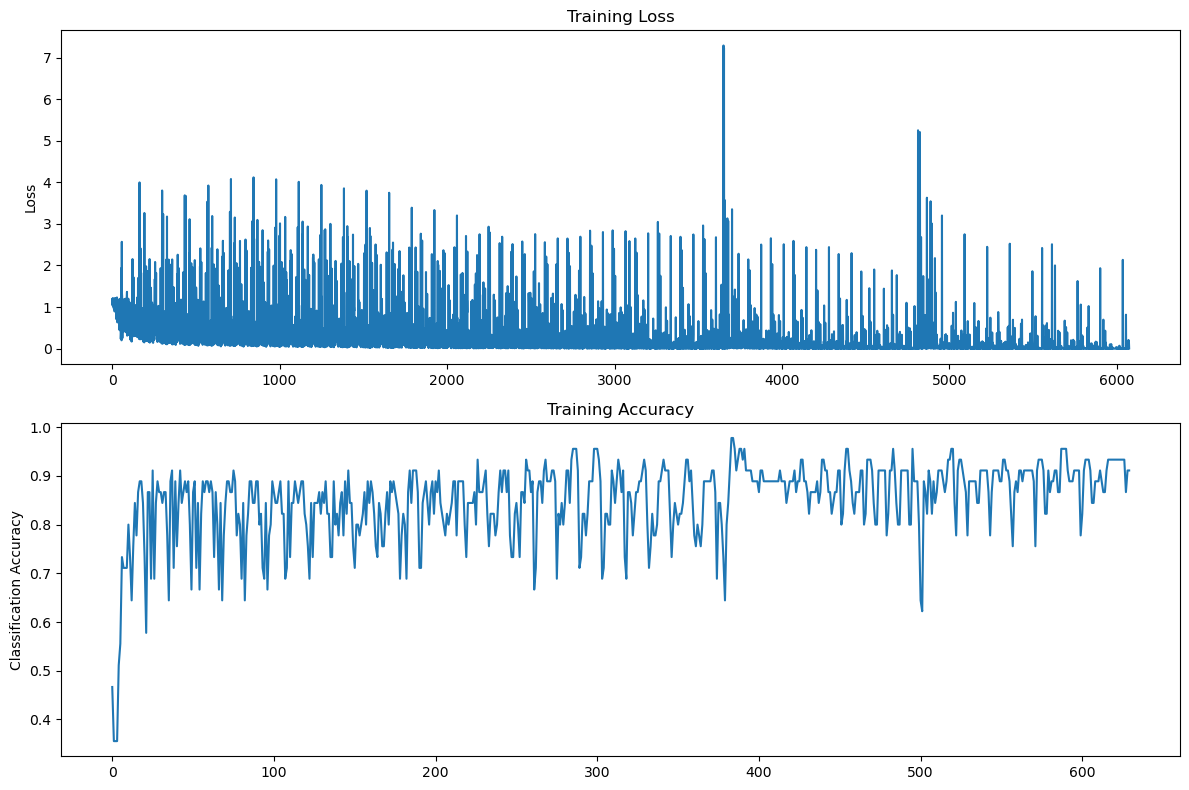

Accuracy: 91.11
--- 51.2401077747345 seconds ---
[2 2 0 2 1 2 2 1 0 2 2 2 2 0 1 1 0 1 0 2 2 0 0 0 0 1 2 1 0 1 0 1 0 2 2 2 1
 1 0 0 1 1 2 1] prediction number
[2 2 0 2 1 2 2 1 0 2 2 2 2 0 1 0 0 0 0 2 2 0 0 0 0 1 2 1 0 1 0 1 0 2 2 2 1
 1 1 0 1 1 2 0] real number


In [8]:
fig, ax = plt.subplots(2, 1, figsize=(12,8))
ax[0].plot(train_loss)
ax[0].set_ylabel('Loss')
ax[0].set_title('Training Loss')

ax[1].plot(train_accuracy)
ax[1].set_ylabel('Classification Accuracy')
ax[1].set_title('Training Accuracy')

plt.tight_layout()
plt.show()
print('Accuracy: %.2f' % (accuracy*100))

print("--- %s seconds ---" % (time.time() - start_time))
test_output = rnn(data_test[:-1].view(-1, 10, 10))
pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
print(pred_y, 'prediction number')
print(test_y[:-1], 'real number')

# Specify a path
PATH = "task2model.pt"

# Save
torch.save(rnn, PATH)